In [1]:
import tsai
from tsai.all import *
print('tsai       :', tsai.__version__)
print('fastai     :', fastai.__version__)
print('fastcore   :', fastcore.__version__)
print('torch      :', torch.__version__)

C:\Users\eason\AppData\Roaming\Python\Python37\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\eason\AppData\Roaming\Python\Python37\site-packages\numpy\.libs\libopenblas.JPIJNSWNNAN3CE6LLI5FWSPHUT2VXMTH.gfortran-win_amd64.dll
C:\Users\eason\AppData\Roaming\Python\Python37\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Users\eason\AppData\Roaming\Python\Python37\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
  stacklevel=1)


tsai       : 0.2.15
fastai     : 2.2.5
fastcore   : 1.3.19
torch      : 1.7.1+cu101


# 0. load data

In [2]:
input_fn = 'F:\\Github\\kaggle drought\\data_ndarray.npz'

In [3]:
data = np.load(open(input_fn, 'rb'))

In [4]:
X_train = data['X_train']

In [5]:
X_train.shape

(118024, 90, 18)

In [6]:
print(np.mean(X_train.flatten()))

1.1619668e-07


In [7]:
print(np.std(X_train.flatten()))

1.0000005


In [8]:
X_valid = data['X_valid']

In [9]:
X_test = data['X_test']

In [10]:
y_train = data['y_train']
y_train = np.array([int(i) for i in y_train])

In [11]:
y_valid = data['y_valid']
y_valid = np.array([int(i) for i in y_valid])

In [12]:
y_test = data['y_test']
y_test = np.array([int(i) for i in y_test])

We need to exchange two axes：
* **number of samples**
* **number of features** (aka variables, dimensions, channels)
* **number of steps** (or length, time steps, sequence steps)

In [13]:
X_train = X_train.transpose(0, 2, 1)
X_train.shape

(118024, 18, 90)

In [14]:
X_valid = X_valid.transpose(0, 2, 1)
X_valid.shape

(20721, 18, 90)

In [15]:
X_test = X_test.transpose(0, 2, 1)
X_test.shape

(102430, 18, 90)

We already have the split:

In [16]:
X, y, splits = combine_split_data([X_train, X_valid], [y_train, y_valid])

In [17]:
X.shape

(138745, 18, 90)

In [18]:
y.shape

(138745,)

In [19]:
splits

((#118024) [0,1,2,3,4,5,6,7,8,9...],
 (#20721) [118024,118025,118026,118027,118028,118029,118030,118031,118032,118033...])

In [20]:
tfms  = [None, [Categorize()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)
dsets

(#138745) [(TSTensor(vars:18, len:90), TensorCategory(2, dtype=torch.int32)),(TSTensor(vars:18, len:90), TensorCategory(0, dtype=torch.int32)),(TSTensor(vars:18, len:90), TensorCategory(1, dtype=torch.int32)),(TSTensor(vars:18, len:90), TensorCategory(0, dtype=torch.int32)),(TSTensor(vars:18, len:90), TensorCategory(0, dtype=torch.int32)),(TSTensor(vars:18, len:90), TensorCategory(0, dtype=torch.int32)),(TSTensor(vars:18, len:90), TensorCategory(2, dtype=torch.int32)),(TSTensor(vars:18, len:90), TensorCategory(0, dtype=torch.int32)),(TSTensor(vars:18, len:90), TensorCategory(0, dtype=torch.int32)),(TSTensor(vars:18, len:90), TensorCategory(1, dtype=torch.int32))...]

# 1. Model and Hyperparameter Tuning

In [21]:
import hyperopt
print(hyperopt.__version__)

0.2.5


In [22]:
from hyperopt import Trials, STATUS_OK, STATUS_FAIL, tpe, fmin, hp

In [23]:
search_space = {
    'batch_size': hp.choice('bs', [256, 512, 1024]),
    'time_steps': hp.choice('ts', [30, 60, 90]),  # lookback window size
    "lr": hp.choice('lr', [0.01, 0.001, 0.0001, 0.00001]),
    "epochs": hp.choice('epochs', [10, 50, 100]),  # we would also use early stopping
    "patience": hp.choice('patience', [5, 10]),  # early stopping patience
    "optimizer": hp.choice('optimizer', [Adam, SGD, RMSProp]),  # https://docs.fast.ai/optimizer
    # model parameters
    "n_layers": hp.choice('n_layers', [1, 2, 3, 4, 5]),
    "d_model": hp.choice('d_model', [64, 128, 256]),
    "n_heads": hp.choice('n_heads', [8, 16, 32])
}

In [24]:
search_space

{'batch_size': <hyperopt.pyll.base.Apply at 0x1faeaf32488>,
 'time_steps': <hyperopt.pyll.base.Apply at 0x1faeaf32ac8>,
 'lr': <hyperopt.pyll.base.Apply at 0x1faeaf34248>,
 'epochs': <hyperopt.pyll.base.Apply at 0x1faeaf34848>,
 'patience': <hyperopt.pyll.base.Apply at 0x1faeaf34dc8>,
 'optimizer': <hyperopt.pyll.base.Apply at 0x1faeaf27288>,
 'n_layers': <hyperopt.pyll.base.Apply at 0x1faeaf27ac8>,
 'd_model': <hyperopt.pyll.base.Apply at 0x1faeaf29088>,
 'n_heads': <hyperopt.pyll.base.Apply at 0x1faeaf296c8>}

In [25]:
X.shape

(138745, 18, 90)

In [26]:
time_steps = 30

In [27]:
X[:, :, -time_steps:].shape

(138745, 18, 30)

In [28]:
X_test[:, :, -time_steps:].shape

(102430, 18, 30)

In [29]:
X, y, splits = combine_split_data([X_train, X_valid], [y_train, y_valid])

In [30]:
import time
from fastai.callback.tracker import EarlyStoppingCallback

In [31]:
import gc

In [32]:
# clear memory 
gc.collect()

183

In [33]:
def create_model_hypopt(params):
    
    try:
        # clear memory 
        gc.collect()
        print("Trying params:",params)
        batch_size = params["batch_size"]
        time_steps = params["time_steps"]
    
        # Create data loader
        tfms  = [None, [Categorize()]]
        dsets = TSDatasets(X[:, :, -time_steps:], y, tfms=tfms, splits=splits, inplace=True)
        # set num_workers for memory bottleneck
        dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[batch_size, batch_size], num_workers=0)
    
        # Create model
        arch = TST
        k = {
            'n_layers': params['n_layers'],
            'd_model': params['d_model'],
            'n_heads': params['n_heads']
        }
        model = create_model(arch, dls=dls, **k)
        print(model.__class__.__name__)
    
        # Training the model
        learn = Learner(dls, model, metrics=accuracy, opt_func=params['optimizer'])
        start = time.time()
        learn.fit_one_cycle(params['epochs'], lr_max=params['lr'],
                            cbs=EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0, patience=params['patience']))
        learn.plot_metrics()
        elapsed = time.time() - start
    
        vals = learn.recorder.values[-1]
        # vals[0], vals[1], vals[2]
        # train loss, valid loss, accuracy
        val_loss = vals[1]
    
        # delete tmp variables
        del dls
        del model
        del learn
        return {'loss': val_loss, 'status': STATUS_OK} # if accuracy use '-' sign, model is optional
    except:
        return {'loss': None, 'status': STATUS_FAIL}

Search the parameters:

Trying params:                                                                                                         
{'batch_size': 512, 'd_model': 256, 'epochs': 100, 'lr': 0.0001, 'n_heads': 32, 'n_layers': 4, 'optimizer': <function RMSProp at 0x000001FAAADCB1F8>, 'patience': 10, 'time_steps': 30}
TST                                                                                                                    
  0%|                                                                           | 0/30 [00:30<?, ?trial/s, best loss=?]

epoch,train_loss,valid_loss,accuracy,time
0,1.034168,1.034785,0.652912,00:21
1,0.991221,1.005726,0.650403,00:19
2,0.974528,0.992070,0.650789,00:19
3,0.961641,0.972310,0.657932,00:19
4,0.952991,0.968586,0.653926,00:20
5,0.941606,0.942010,0.663819,00:20
6,0.931356,0.960578,0.663481,00:19
7,0.928338,0.947884,0.667004,00:19
8,0.921673,0.944089,0.667921,00:19
9,0.916989,0.911703,0.674485,00:19


No improvement since epoch 9: early stopping                                                                           
  0%|                                                                           | 0/30 [07:10<?, ?trial/s, best loss=?]

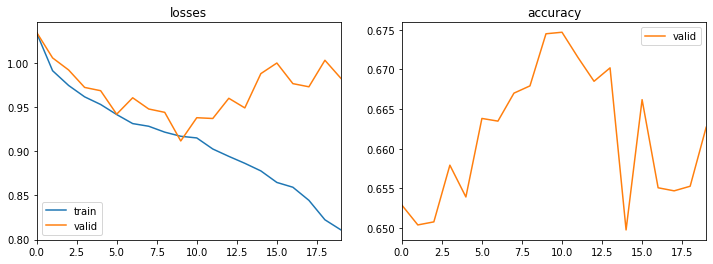

Trying params:                                                                                                         
{'batch_size': 1024, 'd_model': 256, 'epochs': 100, 'lr': 1e-05, 'n_heads': 8, 'n_layers': 1, 'optimizer': <function RMSProp at 0x000001FAAADCB1F8>, 'patience': 5, 'time_steps': 30}
TST                                                                                                                    
  3%|█▌                                            | 1/30 [07:39<3:28:17, 430.95s/trial, best loss: 0.9825672507286072]

epoch,train_loss,valid_loss,accuracy,time
0,1.750284,1.687636,0.342599,00:03
1,1.652680,1.591047,0.449447,00:03
2,1.551191,1.487903,0.531442,00:03
3,1.436427,1.375107,0.593504,00:03
4,1.320415,1.264919,0.624005,00:03
5,1.218946,1.178500,0.637180,00:03
6,1.142035,1.123150,0.644515,00:03
7,1.102020,1.092853,0.645867,00:03
8,1.072600,1.067802,0.647797,00:03
9,1.047282,1.052086,0.649390,00:03


No improvement since epoch 30: early stopping                                                                          
  3%|█▌                                            | 1/30 [09:51<3:28:17, 430.95s/trial, best loss: 0.9825672507286072]

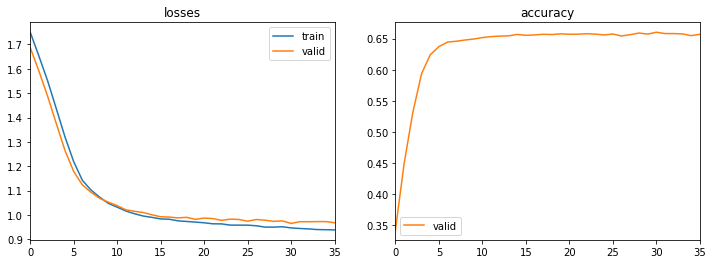

Trying params:                                                                                                         
{'batch_size': 256, 'd_model': 64, 'epochs': 50, 'lr': 0.01, 'n_heads': 16, 'n_layers': 1, 'optimizer': <function RMSProp at 0x000001FAAADCB1F8>, 'patience': 10, 'time_steps': 60}
TST                                                                                                                    
  7%|███                                           | 2/30 [10:22<2:43:15, 349.84s/trial, best loss: 0.9679544568061829]

epoch,train_loss,valid_loss,accuracy,time
0,0.943938,0.928961,0.670286,00:05
1,0.907877,0.922661,0.664398,00:05
2,0.887512,0.895050,0.680759,00:05
3,0.917509,0.946157,0.675305,00:05
4,0.867142,0.938262,0.658269,00:05
5,0.842044,0.960621,0.665991,00:05
6,0.827681,1.114896,0.611360,00:05
7,0.845499,0.984639,0.658028,00:05
8,0.807948,1.025102,0.664495,00:05
9,0.819224,1.041422,0.665315,00:05


No improvement since epoch 2: early stopping                                                                           
  7%|███                                           | 2/30 [11:32<2:43:15, 349.84s/trial, best loss: 0.9679544568061829]

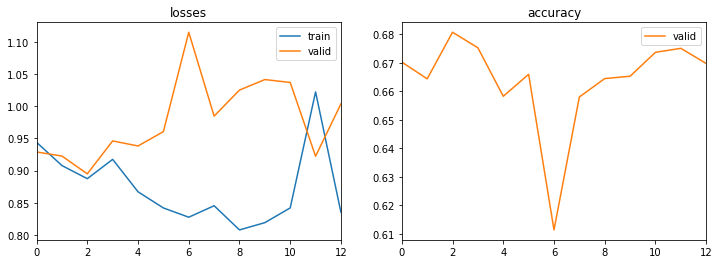

Trying params:                                                                                                         
{'batch_size': 512, 'd_model': 256, 'epochs': 100, 'lr': 0.01, 'n_heads': 16, 'n_layers': 3, 'optimizer': <function RMSProp at 0x000001FAAADCB1F8>, 'patience': 5, 'time_steps': 90}
TST                                                                                                                    
 10%|████▌                                         | 3/30 [12:03<2:03:49, 275.17s/trial, best loss: 0.9679544568061829]

epoch,train_loss,valid_loss,accuracy,time
0,1.110108,1.000312,0.652912,00:37
1,1.106177,0.984765,0.660586,00:37
2,1.034722,1.092084,0.651223,00:37
3,1.158678,1.127344,0.662709,00:37
4,1.296056,1.903497,0.664109,00:37
5,1.638296,1.138119,0.664543,00:37
6,1.326674,1.171780,0.664543,00:38


No improvement since epoch 1: early stopping                                                                           
 10%|████▌                                         | 3/30 [16:27<2:03:49, 275.17s/trial, best loss: 0.9679544568061829]

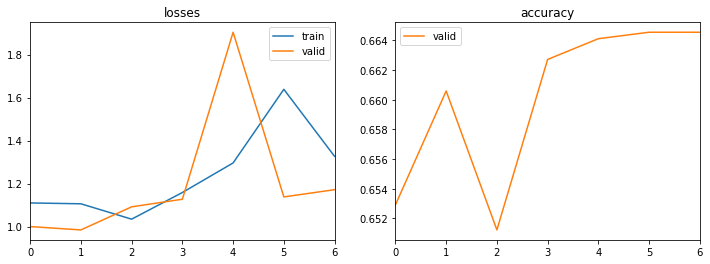

Trying params:                                                                                                         
{'batch_size': 512, 'd_model': 64, 'epochs': 10, 'lr': 0.001, 'n_heads': 8, 'n_layers': 5, 'optimizer': <function Adam at 0x000001FAAADCB438>, 'patience': 10, 'time_steps': 90}
TST                                                                                                                    
 13%|██████▏                                       | 4/30 [16:54<2:01:54, 281.34s/trial, best loss: 0.9679544568061829]

epoch,train_loss,valid_loss,accuracy,time
0,0.924458,0.860836,0.679745,00:23
1,0.869651,0.905682,0.669755,00:23
2,0.814602,0.944083,0.684668,00:23
3,0.758502,0.906587,0.670914,00:23
4,0.696189,0.941303,0.675498,00:23
5,0.642730,0.993858,0.671251,00:23
6,0.596652,1.015306,0.684571,00:23
7,0.552365,1.072112,0.667825,00:23
8,0.526612,1.132419,0.670721,00:23
9,0.505016,1.129840,0.668356,00:23


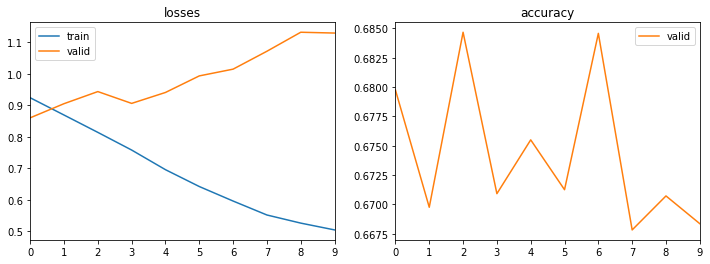

Trying params:                                                                                                         
{'batch_size': 1024, 'd_model': 256, 'epochs': 10, 'lr': 0.001, 'n_heads': 8, 'n_layers': 3, 'optimizer': <function RMSProp at 0x000001FAAADCB1F8>, 'patience': 10, 'time_steps': 60}
TST                                                                                                                    
 17%|███████▋                                      | 5/30 [21:16<1:54:35, 275.03s/trial, best loss: 0.9679544568061829]

epoch,train_loss,valid_loss,accuracy,time
0,1.146354,0.983680,0.651851,00:17
1,1.710089,2.022166,0.664543,00:17
2,1.262750,1.128141,0.664543,00:17
3,1.253812,1.053943,0.664640,00:17
4,1.006845,0.965487,0.656677,00:18
5,0.950040,0.938116,0.654505,00:18
6,0.926815,0.894185,0.661841,00:18
7,0.902918,0.881103,0.665412,00:18
8,0.890174,0.877714,0.668742,00:18
9,0.881137,0.879703,0.671782,00:18


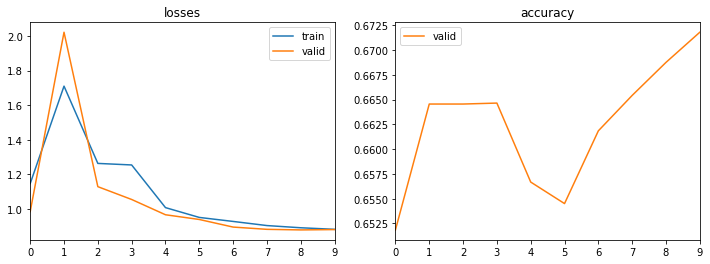

Trying params:                                                                                                         
{'batch_size': 512, 'd_model': 256, 'epochs': 100, 'lr': 0.01, 'n_heads': 8, 'n_layers': 1, 'optimizer': <function Adam at 0x000001FAAADCB438>, 'patience': 5, 'time_steps': 30}
TST                                                                                                                    
 20%|█████████▏                                    | 6/30 [24:48<1:42:04, 255.20s/trial, best loss: 0.8797032833099365]

epoch,train_loss,valid_loss,accuracy,time
0,0.981580,0.999354,0.664012,00:04
1,0.946277,0.954368,0.656146,00:04
2,0.915594,0.978982,0.658366,00:04
3,0.901538,0.966626,0.660538,00:04
4,0.868920,1.022108,0.648810,00:03
5,0.862791,1.018876,0.651706,00:04
6,0.838498,0.960751,0.666908,00:03


No improvement since epoch 1: early stopping                                                                           
 20%|█████████▏                                    | 6/30 [25:17<1:42:04, 255.20s/trial, best loss: 0.8797032833099365]

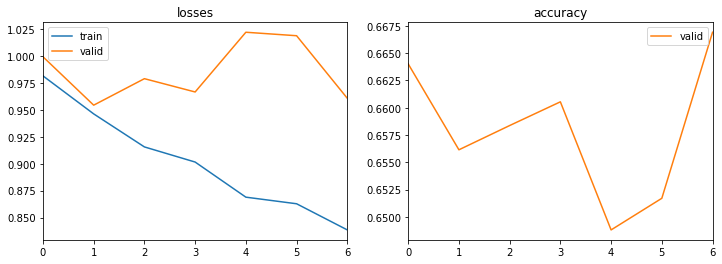

Trying params:                                                                                                         
{'batch_size': 256, 'd_model': 64, 'epochs': 50, 'lr': 0.01, 'n_heads': 32, 'n_layers': 2, 'optimizer': <function Adam at 0x000001FAAADCB438>, 'patience': 5, 'time_steps': 90}
TST                                                                                                                    
 23%|██████████▋                                   | 7/30 [25:45<1:15:22, 196.65s/trial, best loss: 0.8797032833099365]

epoch,train_loss,valid_loss,accuracy,time
0,0.872891,0.853647,0.678008,00:27
1,0.838768,0.894075,0.678587,00:28
2,0.784319,0.920551,0.673134,00:28
3,0.757350,0.948340,0.657642,00:28
4,0.743307,0.971049,0.639448,00:28
5,0.733401,1.011762,0.672120,00:29


No improvement since epoch 0: early stopping                                                                           
 23%|██████████▋                                   | 7/30 [28:37<1:15:22, 196.65s/trial, best loss: 0.8797032833099365]

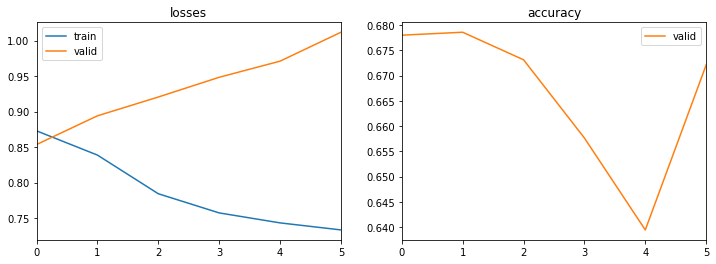

Trying params:                                                                                                         
{'batch_size': 512, 'd_model': 64, 'epochs': 10, 'lr': 1e-05, 'n_heads': 8, 'n_layers': 3, 'optimizer': <function Adam at 0x000001FAAADCB438>, 'patience': 10, 'time_steps': 30}
TST                                                                                                                    
 27%|████████████▎                                 | 8/30 [29:08<1:12:28, 197.65s/trial, best loss: 0.8797032833099365]

epoch,train_loss,valid_loss,accuracy,time
0,1.641421,1.535097,0.448482,00:04
1,1.187342,1.135132,0.658269,00:04
2,1.068807,1.072157,0.654891,00:04
3,1.022772,1.028461,0.659042,00:04
4,1.003405,1.007914,0.657352,00:04
5,0.992678,0.999417,0.656725,00:05
6,0.990920,0.997888,0.656580,00:05
7,0.987867,0.997031,0.656242,00:04
8,0.988442,0.995914,0.656435,00:04
9,0.989712,0.995246,0.656484,00:04


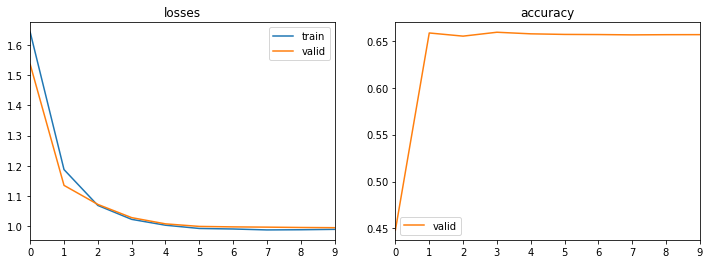

Trying params:                                                                                                         
{'batch_size': 512, 'd_model': 128, 'epochs': 10, 'lr': 0.01, 'n_heads': 32, 'n_layers': 5, 'optimizer': <function Adam at 0x000001FAAADCB438>, 'patience': 10, 'time_steps': 30}
TST                                                                                                                    
 30%|██████████████▍                                 | 9/30 [30:28<56:49, 162.35s/trial, best loss: 0.8797032833099365]

epoch,train_loss,valid_loss,accuracy,time
0,0.968319,1.046958,0.661503,00:19
1,1.150609,1.133647,0.664543,00:20
2,1.076381,1.106187,0.664543,00:19
3,0.983680,0.979870,0.655229,00:19
4,0.964006,0.933869,0.669031,00:19
5,0.941170,0.960881,0.649100,00:19
6,0.927921,0.968669,0.668983,00:19
7,0.906034,0.939355,0.666570,00:19
8,0.889322,0.948346,0.661696,00:19
9,0.886454,0.953670,0.660152,00:19


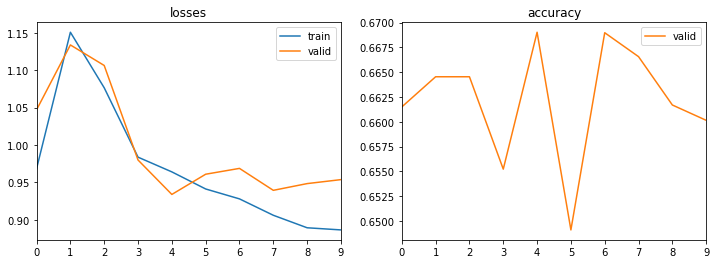

Trying params:                                                                                                         
{'batch_size': 256, 'd_model': 64, 'epochs': 100, 'lr': 0.001, 'n_heads': 32, 'n_layers': 3, 'optimizer': <function SGD at 0x000001FAAADCB0D8>, 'patience': 10, 'time_steps': 90}
TST                                                                                                                    
 33%|███████████████                              | 10/30 [34:13<1:00:39, 181.98s/trial, best loss: 0.8797032833099365]

epoch,train_loss,valid_loss,accuracy,time
0,1.208353,1.195776,0.659862,00:42
1,1.134067,1.146318,0.653685,00:42
2,1.097304,1.109988,0.649969,00:41
3,1.054934,1.074454,0.650162,00:42
4,1.039872,1.044906,0.648473,00:42
5,1.020585,1.031945,0.646349,00:42
6,0.995437,1.010726,0.646542,00:41
7,0.986807,1.001454,0.646108,00:41
8,0.968153,0.979152,0.648859,00:41
9,0.952961,0.969361,0.649486,00:41


No improvement since epoch 31: early stopping                                                                          
 33%|██████████████▎                            | 10/30 [1:03:54<1:00:39, 181.98s/trial, best loss: 0.8797032833099365]

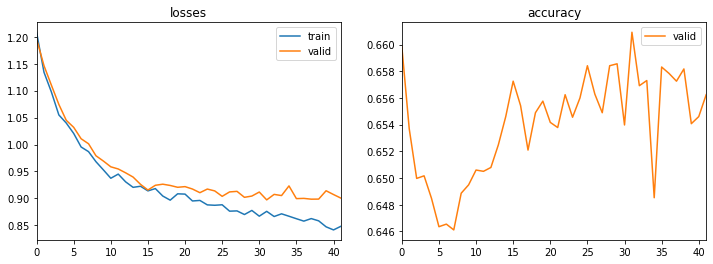

Trying params:                                                                                                         
{'batch_size': 1024, 'd_model': 256, 'epochs': 100, 'lr': 0.01, 'n_heads': 16, 'n_layers': 5, 'optimizer': <function RMSProp at 0x000001FAAADCB1F8>, 'patience': 10, 'time_steps': 90}
TST                                                                                                                    
 37%|███████████████▊                           | 11/30 [1:04:25<3:32:13, 670.19s/trial, best loss: 0.8797032833099365]

epoch,train_loss,valid_loss,accuracy,time


Trying params:                                                                                                         
{'batch_size': 256, 'd_model': 64, 'epochs': 10, 'lr': 0.01, 'n_heads': 8, 'n_layers': 1, 'optimizer': <function Adam at 0x000001FAAADCB438>, 'patience': 10, 'time_steps': 30}
TST                                                                                                                    
 40%|█████████████████▏                         | 12/30 [1:04:56<2:23:34, 478.59s/trial, best loss: 0.8797032833099365]

epoch,train_loss,valid_loss,accuracy,time
0,0.972952,0.986036,0.661696,00:04
1,0.956990,0.969664,0.675884,00:04
2,0.919596,0.956439,0.676657,00:04
3,0.922963,0.975644,0.680855,00:04
4,0.900225,0.969193,0.673182,00:04
5,0.877983,0.986036,0.677863,00:04
6,0.867420,0.970290,0.675691,00:04
7,0.840052,0.981759,0.674195,00:04
8,0.822480,0.994069,0.673230,00:04
9,0.820948,0.991570,0.673954,00:04


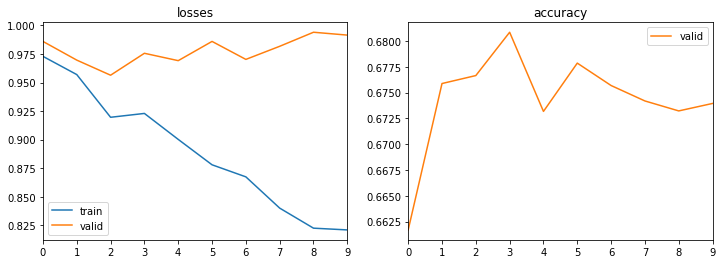

Trying params:                                                                                                         
{'batch_size': 512, 'd_model': 64, 'epochs': 100, 'lr': 1e-05, 'n_heads': 32, 'n_layers': 2, 'optimizer': <function Adam at 0x000001FAAADCB438>, 'patience': 10, 'time_steps': 60}
TST                                                                                                                    
 43%|██████████████████▋                        | 13/30 [1:06:08<1:41:08, 356.95s/trial, best loss: 0.8797032833099365]

epoch,train_loss,valid_loss,accuracy,time
0,1.883822,1.814610,0.210415,00:12
1,1.739344,1.678781,0.319869,00:12
2,1.580970,1.530623,0.463684,00:13
3,1.413948,1.370620,0.571594,00:13
4,1.256864,1.227601,0.626755,00:12
5,1.148740,1.144391,0.646832,00:12
6,1.104126,1.108705,0.651175,00:12
7,1.072963,1.086487,0.652237,00:12
8,1.047614,1.065401,0.651947,00:12
9,1.025674,1.040251,0.651851,00:13


No improvement since epoch 54: early stopping                                                                          
 43%|██████████████████▋                        | 13/30 [1:20:51<1:41:08, 356.95s/trial, best loss: 0.8797032833099365]

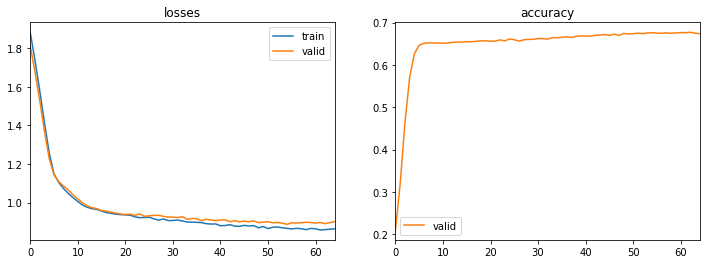

Trying params:                                                                                                         
{'batch_size': 256, 'd_model': 128, 'epochs': 50, 'lr': 0.001, 'n_heads': 32, 'n_layers': 5, 'optimizer': <function RMSProp at 0x000001FAAADCB1F8>, 'patience': 10, 'time_steps': 30}
TST                                                                                                                    
 47%|████████████████████                       | 14/30 [1:21:20<2:19:37, 523.58s/trial, best loss: 0.8797032833099365]

epoch,train_loss,valid_loss,accuracy,time
0,0.964252,0.967800,0.660538,00:20
1,0.946690,0.992292,0.666329,00:20
2,0.933739,1.068695,0.648762,00:20
3,0.916930,0.983745,0.656291,00:20
4,0.884743,1.001174,0.660586,00:20
5,0.856962,1.024977,0.671010,00:20
6,0.808983,1.098163,0.658945,00:21
7,0.775092,1.205436,0.647073,00:21
8,0.722801,1.163762,0.654312,00:21
9,0.685108,1.284067,0.574827,00:21


No improvement since epoch 0: early stopping                                                                           
 47%|████████████████████                       | 14/30 [1:25:09<2:19:37, 523.58s/trial, best loss: 0.8797032833099365]

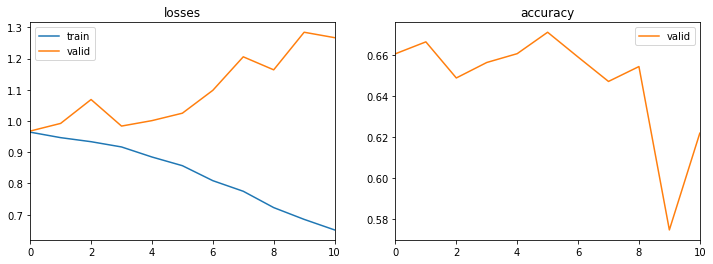

Trying params:                                                                                                         
{'batch_size': 512, 'd_model': 64, 'epochs': 50, 'lr': 0.0001, 'n_heads': 16, 'n_layers': 5, 'optimizer': <function Adam at 0x000001FAAADCB438>, 'patience': 10, 'time_steps': 30}
TST                                                                                                                    
 50%|█████████████████████▌                     | 15/30 [1:25:42<1:51:00, 444.04s/trial, best loss: 0.8797032833099365]

epoch,train_loss,valid_loss,accuracy,time
0,1.235997,1.168936,0.635780,00:10
1,1.066820,1.078633,0.641861,00:10
2,1.003538,1.016613,0.653057,00:11
3,0.987728,0.993557,0.654360,00:11
4,0.970350,0.977293,0.653781,00:10
5,0.959299,0.956769,0.657401,00:10
6,0.946094,0.961294,0.658993,00:10
7,0.944406,0.965766,0.657497,00:10
8,0.930735,0.936819,0.670286,00:10
9,0.922357,0.965741,0.662178,00:10


No improvement since epoch 14: early stopping                                                                          
 50%|█████████████████████▌                     | 15/30 [1:30:13<1:51:00, 444.04s/trial, best loss: 0.8797032833099365]

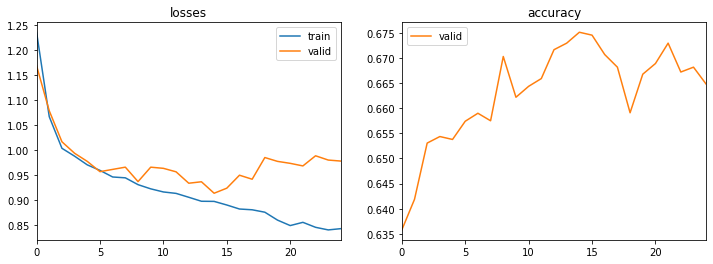

Trying params:                                                                                                         
{'batch_size': 512, 'd_model': 128, 'epochs': 50, 'lr': 1e-05, 'n_heads': 16, 'n_layers': 5, 'optimizer': <function RMSProp at 0x000001FAAADCB1F8>, 'patience': 10, 'time_steps': 90}
TST                                                                                                                    
 53%|██████████████████████▉                    | 16/30 [1:30:43<1:33:45, 401.83s/trial, best loss: 0.8797032833099365]

epoch,train_loss,valid_loss,accuracy,time
0,1.520191,1.450117,0.567058,00:44
1,1.241634,1.214302,0.643453,00:46
2,1.113042,1.122617,0.648666,00:47
3,1.033227,1.054657,0.646639,00:46
4,0.978218,0.995156,0.651609,00:47
5,0.946956,0.960093,0.654553,00:48
6,0.932988,0.936828,0.657159,00:48
7,0.919734,0.923251,0.658269,00:46
8,0.904137,0.897727,0.663964,00:47
9,0.898868,0.882002,0.667149,00:47


No improvement since epoch 16: early stopping                                                                          
 53%|██████████████████████▉                    | 16/30 [1:52:24<1:33:45, 401.83s/trial, best loss: 0.8797032833099365]

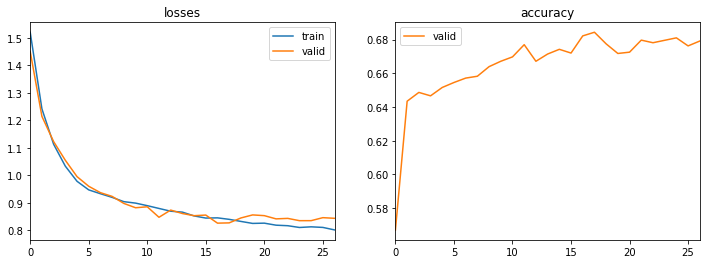

Trying params:                                                                                                         
{'batch_size': 1024, 'd_model': 256, 'epochs': 50, 'lr': 0.01, 'n_heads': 16, 'n_layers': 3, 'optimizer': <function Adam at 0x000001FAAADCB438>, 'patience': 5, 'time_steps': 60}
TST                                                                                                                    
 57%|████████████████████████▎                  | 17/30 [1:52:55<2:27:27, 680.54s/trial, best loss: 0.8435987830162048]

epoch,train_loss,valid_loss,accuracy,time
0,0.960076,0.956107,0.656339,00:25
1,0.900858,0.943176,0.666570,00:26
2,0.873948,0.970536,0.655760,00:26
3,0.843802,1.024828,0.658028,00:26
4,1.438033,1.399976,0.662275,00:26
5,1.398130,1.152525,0.664543,00:26
6,1.219340,1.145880,0.664543,00:26


No improvement since epoch 1: early stopping                                                                           
 57%|████████████████████████▎                  | 17/30 [1:55:59<2:27:27, 680.54s/trial, best loss: 0.8435987830162048]

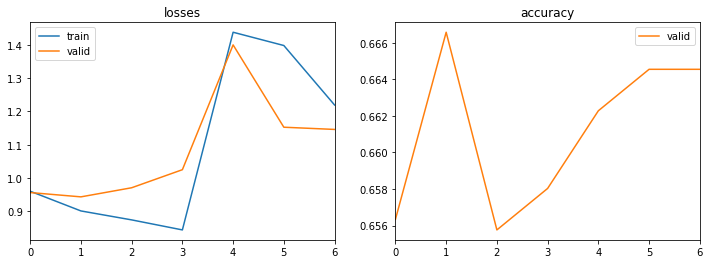

Trying params:                                                                                                         
{'batch_size': 512, 'd_model': 128, 'epochs': 50, 'lr': 1e-05, 'n_heads': 8, 'n_layers': 2, 'optimizer': <function RMSProp at 0x000001FAAADCB1F8>, 'patience': 10, 'time_steps': 90}
TST                                                                                                                    
 60%|█████████████████████████▊                 | 18/30 [1:56:28<1:48:11, 540.96s/trial, best loss: 0.8435987830162048]

epoch,train_loss,valid_loss,accuracy,time
0,1.680165,1.658456,0.399353,00:12
1,1.366998,1.334119,0.608561,00:13
2,1.152729,1.148379,0.649486,00:13
3,1.076789,1.081020,0.652961,00:13
4,1.027419,1.021164,0.653926,00:13
5,0.981808,0.975880,0.655036,00:13
6,0.956041,0.945207,0.657546,00:13
7,0.934794,0.927033,0.657594,00:13
8,0.918332,0.906847,0.660103,00:13
9,0.911888,0.910055,0.659862,00:14


No improvement since epoch 34: early stopping                                                                          
 60%|█████████████████████████▊                 | 18/30 [2:06:54<1:48:11, 540.96s/trial, best loss: 0.8435987830162048]

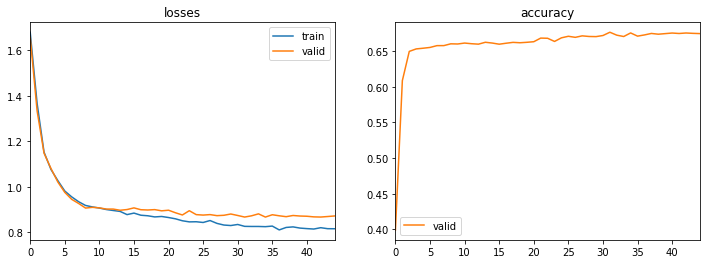

Trying params:                                                                                                         
{'batch_size': 1024, 'd_model': 128, 'epochs': 10, 'lr': 0.01, 'n_heads': 32, 'n_layers': 2, 'optimizer': <function Adam at 0x000001FAAADCB438>, 'patience': 5, 'time_steps': 60}
TST                                                                                                                    
 63%|███████████████████████████▏               | 19/30 [2:07:23<1:45:28, 575.33s/trial, best loss: 0.8435987830162048]

epoch,train_loss,valid_loss,accuracy,time
0,1.001705,1.045968,0.621302,00:14
1,1.019415,3.823450,0.499445,00:14
2,1.335306,1.149147,0.663868,00:14
3,1.046065,0.975842,0.652575,00:15
4,0.950874,0.933941,0.658125,00:15
5,0.919015,0.917511,0.662034,00:15
6,0.899336,0.917380,0.657352,00:15
7,0.887877,0.926641,0.656629,00:15
8,0.877375,0.902455,0.656918,00:15
9,0.869442,0.911036,0.655181,00:15


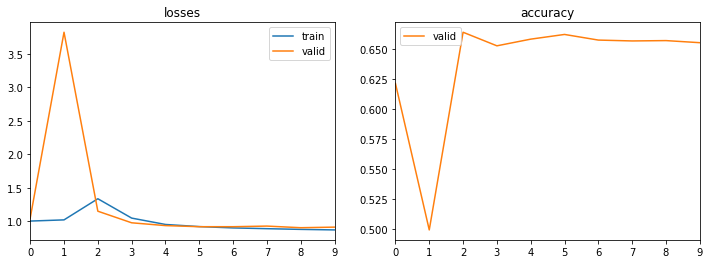

Trying params:                                                                                                         
{'batch_size': 512, 'd_model': 128, 'epochs': 50, 'lr': 1e-05, 'n_heads': 16, 'n_layers': 2, 'optimizer': <function SGD at 0x000001FAAADCB0D8>, 'patience': 10, 'time_steps': 90}
TST                                                                                                                    
 67%|████████████████████████████▋              | 20/30 [2:10:20<1:16:03, 456.32s/trial, best loss: 0.8435987830162048]

epoch,train_loss,valid_loss,accuracy,time
0,1.916252,1.942958,0.194826,00:18
1,1.880415,1.895563,0.205540,00:18
2,1.814222,1.815548,0.232663,00:18
3,1.721512,1.704274,0.302350,00:19
4,1.606563,1.572932,0.443994,00:19
5,1.488130,1.442112,0.569374,00:19
6,1.377402,1.332121,0.629410,00:19
7,1.293148,1.248595,0.649872,00:19
8,1.230803,1.190360,0.655712,00:19
9,1.185154,1.152767,0.657787,00:19


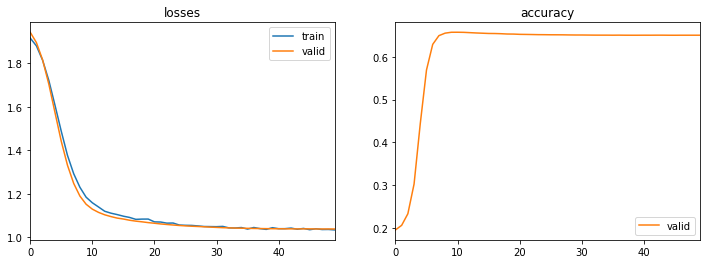

Trying params:                                                                                                         
{'batch_size': 512, 'd_model': 128, 'epochs': 50, 'lr': 1e-05, 'n_heads': 16, 'n_layers': 4, 'optimizer': <function RMSProp at 0x000001FAAADCB1F8>, 'patience': 10, 'time_steps': 90}
TST                                                                                                                    
 70%|██████████████████████████████             | 21/30 [2:27:04<1:33:06, 620.70s/trial, best loss: 0.8435987830162048]

epoch,train_loss,valid_loss,accuracy,time
0,1.308518,1.239985,0.659186,00:35
1,1.145715,1.136172,0.658221,00:36
2,1.081203,1.097170,0.653878,00:37
3,1.036420,1.041689,0.650596,00:37
4,0.985030,0.988671,0.650982,00:38
5,0.958551,0.959580,0.651658,00:38
6,0.930564,0.926990,0.655615,00:38
7,0.925025,0.922516,0.656918,00:38
8,0.911962,0.903497,0.660007,00:38
9,0.897605,0.888197,0.664254,00:38


No improvement since epoch 25: early stopping                                                                          
 70%|██████████████████████████████             | 21/30 [2:49:54<1:33:06, 620.70s/trial, best loss: 0.8435987830162048]

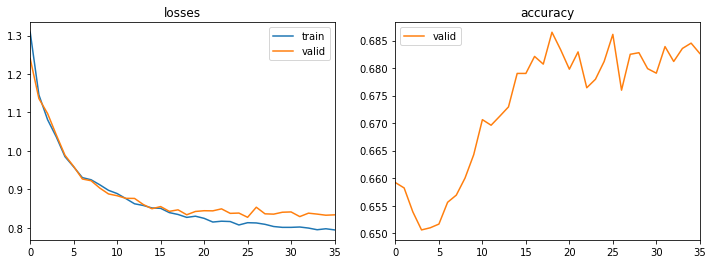

Trying params:                                                                                                         
{'batch_size': 512, 'd_model': 128, 'epochs': 50, 'lr': 1e-05, 'n_heads': 16, 'n_layers': 4, 'optimizer': <function SGD at 0x000001FAAADCB0D8>, 'patience': 10, 'time_steps': 90}
TST                                                                                                                    
 73%|███████████████████████████████▌           | 22/30 [2:50:21<1:53:49, 853.65s/trial, best loss: 0.8338162899017334]

epoch,train_loss,valid_loss,accuracy,time
0,1.841007,1.790825,0.184692,00:35
1,1.754220,1.696671,0.287100,00:36
2,1.623381,1.559662,0.448000,00:37
3,1.467979,1.404815,0.585396,00:37
4,1.335500,1.275724,0.643164,00:37
5,1.244784,1.196686,0.658028,00:38
6,1.199233,1.155041,0.660489,00:38
7,1.162865,1.136557,0.660393,00:38
8,1.147729,1.128026,0.658945,00:38
9,1.130795,1.122837,0.656484,00:37


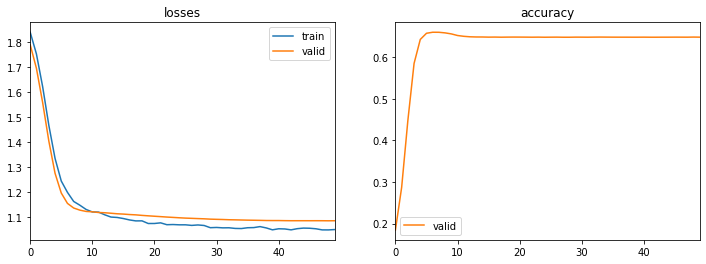

Trying params:                                                                                                         
{'batch_size': 512, 'd_model': 128, 'epochs': 50, 'lr': 1e-05, 'n_heads': 16, 'n_layers': 4, 'optimizer': <function RMSProp at 0x000001FAAADCB1F8>, 'patience': 10, 'time_steps': 90}
TST                                                                                                                    
 77%|████████████████████████████████▏         | 23/30 [3:22:41<2:17:33, 1179.01s/trial, best loss: 0.8338162899017334]

epoch,train_loss,valid_loss,accuracy,time
0,1.406693,1.363968,0.623039,00:35
1,1.190741,1.190584,0.654891,00:36
2,1.091876,1.134021,0.647797,00:37
3,1.044935,1.074996,0.649341,00:38
4,0.992871,1.014008,0.649390,00:37
5,0.960042,0.975251,0.652961,00:38
6,0.939609,0.951552,0.650306,00:38
7,0.917704,0.919142,0.659814,00:38
8,0.911918,0.904239,0.662227,00:38
9,0.903377,0.902297,0.662420,00:38


No improvement since epoch 27: early stopping                                                                          
 77%|████████████████████████████████▏         | 23/30 [3:46:47<2:17:33, 1179.01s/trial, best loss: 0.8338162899017334]

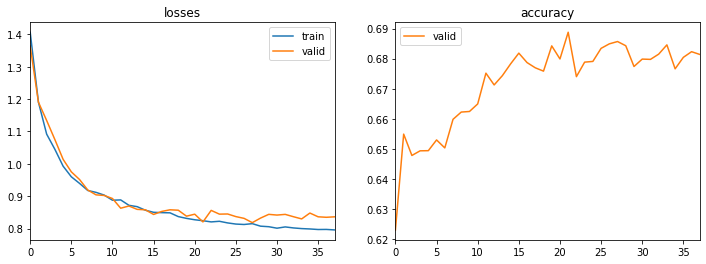

Trying params:                                                                                                         
{'batch_size': 512, 'd_model': 128, 'epochs': 50, 'lr': 1e-05, 'n_heads': 16, 'n_layers': 4, 'optimizer': <function RMSProp at 0x000001FAAADCB1F8>, 'patience': 10, 'time_steps': 90}
TST                                                                                                                    
 80%|█████████████████████████████████▌        | 24/30 [3:47:16<2:06:46, 1267.67s/trial, best loss: 0.8338162899017334]

epoch,train_loss,valid_loss,accuracy,time
0,1.464674,1.392112,0.608851,00:35
1,1.211709,1.182997,0.652526,00:36
2,1.098120,1.113503,0.647604,00:37
3,1.043953,1.058250,0.646590,00:37
4,0.992324,0.996436,0.652285,00:37
5,0.957379,0.952895,0.657932,00:38
6,0.942017,0.929046,0.658607,00:37
7,0.920352,0.919868,0.658125,00:38
8,0.919821,0.906916,0.662227,00:38
9,0.901801,0.905125,0.660393,00:38


No improvement since epoch 23: early stopping                                                                          
 80%|█████████████████████████████████▌        | 24/30 [4:08:46<2:06:46, 1267.67s/trial, best loss: 0.8338162899017334]

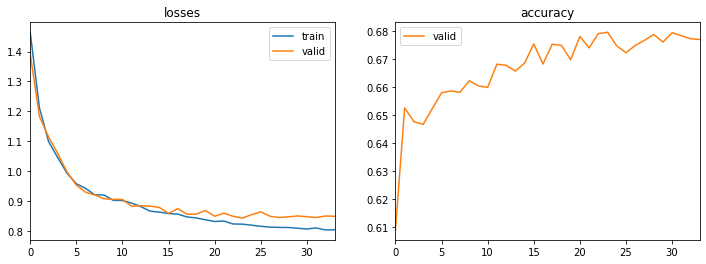

Trying params:                                                                                                         
{'batch_size': 512, 'd_model': 128, 'epochs': 50, 'lr': 0.0001, 'n_heads': 16, 'n_layers': 4, 'optimizer': <function RMSProp at 0x000001FAAADCB1F8>, 'patience': 10, 'time_steps': 90}
TST                                                                                                                    
 83%|███████████████████████████████████       | 25/30 [4:09:15<1:46:55, 1283.10s/trial, best loss: 0.8338162899017334]

epoch,train_loss,valid_loss,accuracy,time
0,1.019425,1.009614,0.645432,00:35
1,0.958555,0.959205,0.652140,00:36
2,0.918799,0.909129,0.661165,00:37
3,0.898284,0.886046,0.671637,00:37
4,0.881670,0.877782,0.672747,00:37
5,0.853629,0.881894,0.665412,00:38
6,0.846682,0.877169,0.674823,00:37
7,0.835788,0.875908,0.669176,00:39
8,0.821818,0.878288,0.675450,00:38
9,0.812085,0.907572,0.656918,00:38


No improvement since epoch 7: early stopping                                                                           
 83%|███████████████████████████████████       | 25/30 [4:20:46<1:46:55, 1283.10s/trial, best loss: 0.8338162899017334]

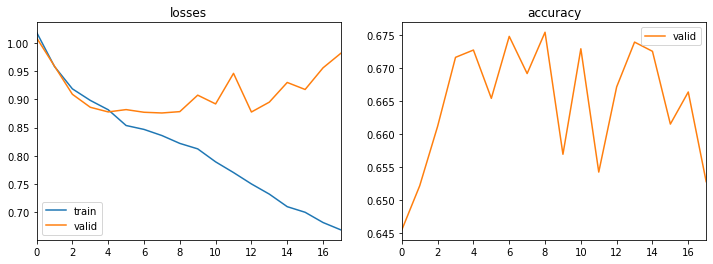

Trying params:                                                                                                         
{'batch_size': 512, 'd_model': 128, 'epochs': 50, 'lr': 1e-05, 'n_heads': 16, 'n_layers': 4, 'optimizer': <function SGD at 0x000001FAAADCB0D8>, 'patience': 10, 'time_steps': 90}
TST                                                                                                                    
 87%|████████████████████████████████████▍     | 26/30 [4:21:15<1:14:15, 1113.98s/trial, best loss: 0.8338162899017334]

epoch,train_loss,valid_loss,accuracy,time
0,1.910916,1.879317,0.148786,00:35
1,1.847050,1.802827,0.206023,00:37
2,1.740815,1.689765,0.301530,00:37
3,1.605697,1.549441,0.467111,00:37
4,1.469241,1.418433,0.584769,00:38
5,1.359421,1.315742,0.630665,00:38
6,1.280949,1.247257,0.651223,00:39
7,1.234438,1.206801,0.656966,00:39
8,1.202869,1.183834,0.657449,00:39
9,1.183618,1.166989,0.656484,00:39


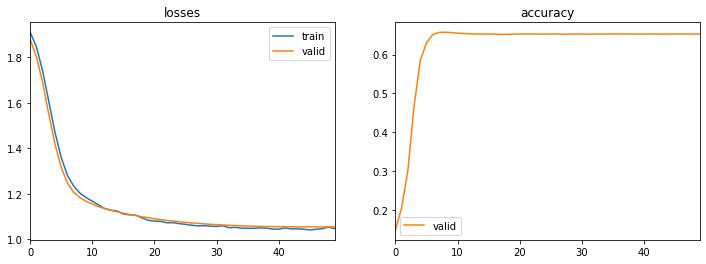

Trying params:                                                                                                         
{'batch_size': 512, 'd_model': 128, 'epochs': 50, 'lr': 1e-05, 'n_heads': 16, 'n_layers': 4, 'optimizer': <function RMSProp at 0x000001FAAADCB1F8>, 'patience': 10, 'time_steps': 90}
TST                                                                                                                    
 90%|█████████████████████████████████████▊    | 27/30 [4:54:28<1:08:50, 1376.97s/trial, best loss: 0.8338162899017334]

epoch,train_loss,valid_loss,accuracy,time
0,1.521543,1.484008,0.556054,00:36
1,1.259418,1.256292,0.651754,00:38
2,1.123930,1.165723,0.648473,00:38
3,1.060014,1.093222,0.652430,00:39
4,1.004213,1.024646,0.653057,00:38
5,0.961612,0.968994,0.654119,00:39
6,0.939447,0.939361,0.655663,00:38
7,0.922030,0.928529,0.658511,00:39
8,0.906925,0.903724,0.660634,00:40
9,0.895856,0.891511,0.661985,00:39


No improvement since epoch 27: early stopping                                                                          
 90%|█████████████████████████████████████▊    | 27/30 [5:19:15<1:08:50, 1376.97s/trial, best loss: 0.8338162899017334]

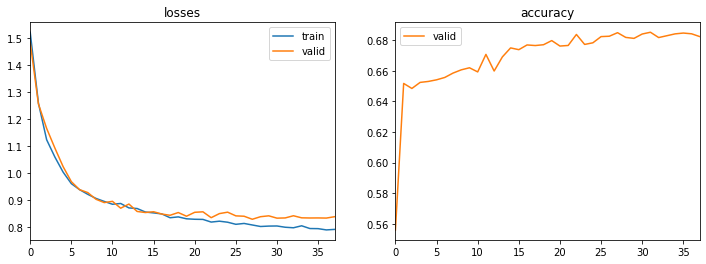

Trying params:                                                                                                         
{'batch_size': 512, 'd_model': 128, 'epochs': 50, 'lr': 0.0001, 'n_heads': 16, 'n_layers': 4, 'optimizer': <function RMSProp at 0x000001FAAADCB1F8>, 'patience': 10, 'time_steps': 90}
TST                                                                                                                    
 93%|█████████████████████████████████████████   | 28/30 [5:19:44<47:19, 1419.51s/trial, best loss: 0.8338162899017334]

epoch,train_loss,valid_loss,accuracy,time
0,1.054033,1.063945,0.656725,00:35
1,0.975344,0.960633,0.659090,00:37
2,0.939742,0.920607,0.663240,00:38
3,0.908311,0.895570,0.660827,00:38
4,0.901797,0.881460,0.668887,00:38
5,0.880508,0.857940,0.678442,00:38
6,0.859394,0.869476,0.678490,00:39
7,0.846905,0.920180,0.646687,00:38
8,0.829397,0.981200,0.616090,00:38
9,0.821434,0.902589,0.650789,00:38


No improvement since epoch 5: early stopping                                                                           
 93%|█████████████████████████████████████████   | 28/30 [5:30:01<47:19, 1419.51s/trial, best loss: 0.8338162899017334]

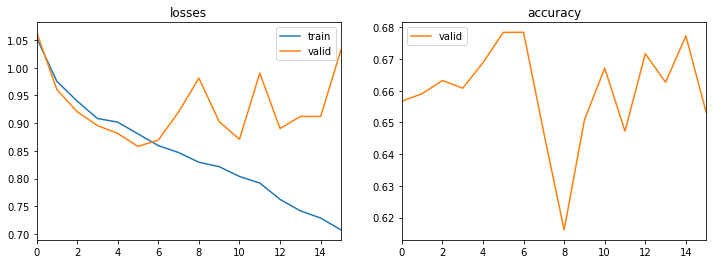

Trying params:                                                                                                         
{'batch_size': 512, 'd_model': 128, 'epochs': 50, 'lr': 1e-05, 'n_heads': 16, 'n_layers': 4, 'optimizer': <function RMSProp at 0x000001FAAADCB1F8>, 'patience': 5, 'time_steps': 90}
TST                                                                                                                    
 97%|██████████████████████████████████████████▌ | 29/30 [5:30:29<19:47, 1187.41s/trial, best loss: 0.8338162899017334]

epoch,train_loss,valid_loss,accuracy,time
0,1.498615,1.460958,0.553207,00:35
1,1.254583,1.262724,0.646253,00:36
2,1.136425,1.174838,0.643260,00:38
3,1.066741,1.092252,0.647266,00:38
4,1.009319,1.015611,0.649341,00:39
5,0.970301,0.972470,0.652044,00:38
6,0.946011,0.939360,0.654891,00:38
7,0.924366,0.919400,0.658655,00:38
8,0.911410,0.905810,0.661985,00:39
9,0.897041,0.894904,0.664784,00:39


No improvement since epoch 21: early stopping                                                                          
 97%|██████████████████████████████████████████▌ | 29/30 [5:48:00<19:47, 1187.41s/trial, best loss: 0.8338162899017334]

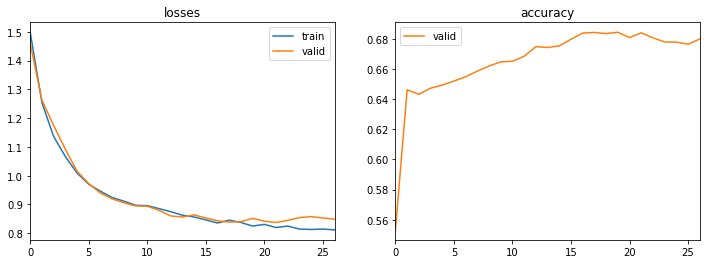

100%|█████████████████████████████████████████████| 30/30 [5:48:00<00:00, 696.03s/trial, best loss: 0.8338162899017334]


In [34]:
trials = Trials()
best = fmin(create_model_hypopt,
    space=search_space,
    algo=tpe.suggest,
    max_evals=30,  # test trials
    trials=trials)

In [35]:
print(best)

{'bs': 1, 'd_model': 1, 'epochs': 1, 'lr': 3, 'n_heads': 1, 'n_layers': 3, 'optimizer': 2, 'patience': 1, 'ts': 2}


In [36]:
from hyperopt import space_eval

In [37]:
print("Best parameters:")
print(space_eval(search_space, best))

Best parameters:
{'batch_size': 512, 'd_model': 128, 'epochs': 50, 'lr': 1e-05, 'n_heads': 16, 'n_layers': 4, 'optimizer': <function RMSProp at 0x000001FAAADCB1F8>, 'patience': 10, 'time_steps': 90}


In [38]:
best_parameters = space_eval(search_space, best)

In [39]:
def build_model(params):
    # clear memory 
    gc.collect()
    print("Trying params:",params)
    batch_size = params["batch_size"]
    time_steps = params["time_steps"]
    
    # Create data loader
    tfms  = [None, [Categorize()]]
    dsets = TSDatasets(X[:, :, -time_steps:], y, tfms=tfms, splits=splits, inplace=True)
    # set num_workers for memory bottleneck
    dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[batch_size, batch_size], num_workers=0)
    
    # Create model
    arch = TST
    k = {
        'n_layers': params['n_layers'],
        'd_model': params['d_model'],
        'n_heads': params['n_heads']
    }
    model = create_model(arch, dls=dls, **k)
    print(model.__class__.__name__)
    
    # Training the model
    learn = Learner(dls, model, metrics=accuracy, opt_func=params['optimizer'])
    start = time.time()
    learn.fit_one_cycle(params['epochs'], lr_max=params['lr'],
                        cbs=EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0, patience=params['patience']))
    learn.plot_metrics()
    elapsed = time.time() - start
    
    # delete tmp variables
    del dls
    del model
    return learn

Trying params: {'batch_size': 512, 'd_model': 128, 'epochs': 50, 'lr': 1e-05, 'n_heads': 16, 'n_layers': 4, 'optimizer': <function RMSProp at 0x000001FAAADCB1F8>, 'patience': 10, 'time_steps': 90}
TST


epoch,train_loss,valid_loss,accuracy,time
0,1.461641,1.394490,0.598861,00:36
1,1.233850,1.194778,0.661261,00:37
2,1.101863,1.100464,0.657111,00:38
3,1.026157,1.040282,0.651175,00:39
4,0.973781,0.993521,0.650596,00:40
5,0.953687,0.960506,0.651706,00:40
6,0.942296,0.940102,0.654023,00:39
7,0.929505,0.922083,0.655760,00:38
8,0.921961,0.925920,0.657401,00:38
9,0.903440,0.893469,0.661213,00:38


No improvement since epoch 21: early stopping


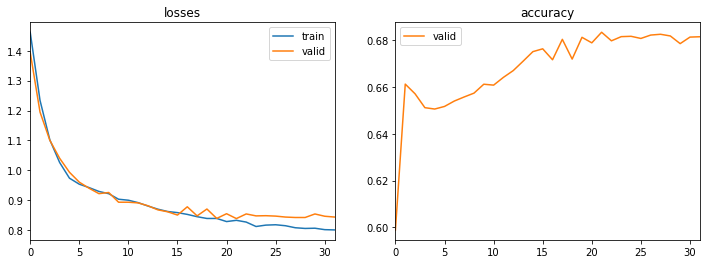

In [40]:
learn = build_model(best_parameters)

In [41]:
dls = learn.dls
valid_dl = dls.valid

In [42]:
time_steps = best_parameters["time_steps"]
X_test_tmp = X_test[:, :, -time_steps:]

In [43]:
test_ds = valid_dl.dataset.add_test(X_test_tmp, y_test)  # use the test data
test_dl = valid_dl.new(test_ds)
print(test_dl.n)

102430


In [44]:
test_probas, test_targets, test_preds = learn.get_preds(dl=test_dl, with_decoded=True, save_preds=None, save_targs=None)
test_probas, test_targets, test_preds

(tensor([[2.6771e-01, 3.3404e-01, 2.3720e-01, 1.1739e-01, 4.1509e-02, 2.1386e-03],
         [9.4669e-01, 3.0324e-02, 2.1475e-02, 1.3772e-03, 1.3538e-04, 7.4935e-07],
         [9.9842e-01, 1.4461e-03, 1.2532e-04, 4.3528e-06, 4.1465e-08, 2.9057e-10],
         ...,
         [9.7372e-01, 1.9859e-02, 5.5067e-03, 8.4103e-04, 6.6629e-05, 2.1882e-06],
         [9.9666e-01, 2.3472e-03, 7.2100e-04, 2.4998e-04, 2.2600e-05, 3.1953e-07],
         [9.4359e-01, 4.0582e-02, 1.4320e-02, 1.3546e-03, 1.4921e-04, 4.5235e-06]]),
 TensorCategory([1, 0, 0,  ..., 0, 0, 0], dtype=torch.int32),
 tensor([1, 0, 0,  ..., 0, 0, 0]))

In [45]:
print(f'accuracy: {skm.accuracy_score(test_targets, test_preds):10.6f}')
print(f'f1 score: {skm.f1_score(test_targets, test_preds, average="weighted"):10.6f}')

accuracy:   0.729503
f1 score:   0.692730


Save the true and predicted results:

In [46]:
y_test_true = test_targets.numpy()
y_test_pred = test_preds.numpy()

In [47]:
np.save('y_true_TST', y_test_true)
np.save('y_pred_TST', y_test_pred)